In [6]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
import pandas as pd

# Step 1: Load the dataset and collect unique moves
data = pd.read_csv("chess_games.txt", header=None, names=["text"])

# Extract unique moves from the dataset
all_moves = set()
for game in data["text"]:
    moves = game.split()  # Split each game by whitespace to get individual moves
    all_moves.update(moves)

# Step 2: Add [UNK] to the vocabulary for unknown tokens
vocab = {move: idx for idx, move in enumerate(all_moves)}
vocab["[UNK]"] = len(vocab)  # Add [UNK] token

# Step 3: Initialize a WordLevel tokenizer with the unique moves as the vocabulary
tokenizer = Tokenizer(WordLevel(vocab, unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Save the tokenizer
tokenizer.save("chess_tokenizer.json")

In [9]:
from transformers import GPT2LMHeadModel, GPT2Config, GPT2TokenizerFast, Trainer, TrainingArguments
from datasets import Dataset
import time
import pandas as pd

# Load the custom tokenizer
tokenizer = GPT2TokenizerFast(tokenizer_file="chess_tokenizer.json")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

# Load the dataset and split it into training and testing sets
data = pd.read_csv("chess_games.txt", header=None, names=["text"])
dataset = Dataset.from_pandas(data)
dataset = dataset.train_test_split(test_size=0.1)

# Define a custom GPT-2 model configuration with a reduced vocabulary size
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=512,
    n_embd=512,
    n_layer=6,
    n_head=8,
)

# Initialize the model with the custom configuration
model = GPT2LMHeadModel(config)
model.resize_token_embeddings(len(tokenizer))

# Tokenize the dataset and prepare labels
def tokenize_function(examples):
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    learning_rate=5e-4,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    max_steps=5000,
    num_train_epochs=5,
    logging_dir='./logs',
    report_to="none",
)

# Define a custom callback for epoch progress tracking
class EpochProgressCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"\nStarting Epoch {int(state.epoch + 1)}/{int(args.num_train_epochs)}")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_time = time.time() - self.epoch_start_time
        print(f"Epoch {int(state.epoch + 1)} completed in {epoch_time:.2f} seconds.")
        remaining_time = epoch_time * (args.num_train_epochs - state.epoch - 1)
        print(f"Estimated time remaining: {remaining_time / 60:.2f} minutes.\n")

# Initialize the Trainer with the model, tokenizer, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    callbacks=[EpochProgressCallback()],
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("chess_gpt_from_scratch")
tokenizer.save_pretrained("chess_gpt_from_scratch")












Map: 100%|██████████| 18052/18052 [00:01<00:00, 16131.08 examples/s]


Map: 100%|██████████| 2006/2006 [00:00<00:00, 16982.15 examples/s]
/Users/robertbecker/miniconda3/envs/env2/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
  0%|          | 0/5000 [00:00<?, ?it/s]


Starting Epoch 1/5


  1%|          | 51/5000 [00:09<15:29,  5.32it/s] 

{'loss': 4.5584, 'grad_norm': 1.2183184623718262, 'learning_rate': 0.000495, 'epoch': 0.02}


  2%|▏         | 100/5000 [00:18<15:02,  5.43it/s]

{'loss': 2.9443, 'grad_norm': 0.712640106678009, 'learning_rate': 0.00049, 'epoch': 0.04}


  3%|▎         | 151/5000 [00:28<14:34,  5.55it/s]

{'loss': 2.8086, 'grad_norm': 0.4987834393978119, 'learning_rate': 0.00048499999999999997, 'epoch': 0.07}


  4%|▍         | 201/5000 [00:37<14:13,  5.62it/s]

{'loss': 2.8213, 'grad_norm': 0.44151628017425537, 'learning_rate': 0.00048, 'epoch': 0.09}


  5%|▌         | 251/5000 [00:46<14:26,  5.48it/s]

{'loss': 2.762, 'grad_norm': 0.6449576616287231, 'learning_rate': 0.000475, 'epoch': 0.11}


  6%|▌         | 301/5000 [00:55<14:36,  5.36it/s]

{'loss': 2.7056, 'grad_norm': 0.6381363868713379, 'learning_rate': 0.00047, 'epoch': 0.13}


  7%|▋         | 351/5000 [01:05<14:20,  5.40it/s]

{'loss': 2.6579, 'grad_norm': 0.609149158000946, 'learning_rate': 0.000465, 'epoch': 0.16}


  8%|▊         | 401/5000 [01:14<14:10,  5.41it/s]

{'loss': 2.6835, 'grad_norm': 0.6913580894470215, 'learning_rate': 0.00046, 'epoch': 0.18}


  9%|▉         | 451/5000 [01:22<13:40,  5.54it/s]

{'loss': 2.5329, 'grad_norm': 0.5471497178077698, 'learning_rate': 0.000455, 'epoch': 0.2}


 10%|█         | 501/5000 [01:31<13:50,  5.42it/s]

{'loss': 2.7349, 'grad_norm': 0.6165074110031128, 'learning_rate': 0.00045000000000000004, 'epoch': 0.22}


 11%|█         | 550/5000 [01:40<13:33,  5.47it/s]

{'loss': 2.6156, 'grad_norm': 0.6117269396781921, 'learning_rate': 0.00044500000000000003, 'epoch': 0.24}


 12%|█▏        | 601/5000 [01:49<13:12,  5.55it/s]

{'loss': 2.5945, 'grad_norm': 0.5484722852706909, 'learning_rate': 0.00044, 'epoch': 0.27}


 13%|█▎        | 651/5000 [01:58<13:29,  5.37it/s]

{'loss': 2.7386, 'grad_norm': 0.703528642654419, 'learning_rate': 0.000435, 'epoch': 0.29}


 14%|█▍        | 701/5000 [02:07<12:57,  5.53it/s]

{'loss': 2.5678, 'grad_norm': 0.5177947282791138, 'learning_rate': 0.00043, 'epoch': 0.31}


 15%|█▌        | 751/5000 [02:17<12:57,  5.46it/s]

{'loss': 2.4861, 'grad_norm': 0.5913086533546448, 'learning_rate': 0.000425, 'epoch': 0.33}


 16%|█▌        | 801/5000 [02:26<12:45,  5.48it/s]

{'loss': 2.5557, 'grad_norm': 0.5088812708854675, 'learning_rate': 0.00042, 'epoch': 0.35}


 17%|█▋        | 851/5000 [02:35<12:30,  5.53it/s]

{'loss': 2.5289, 'grad_norm': 0.6163560152053833, 'learning_rate': 0.000415, 'epoch': 0.38}


 18%|█▊        | 901/5000 [02:44<13:27,  5.07it/s]

{'loss': 2.3695, 'grad_norm': 0.5083364248275757, 'learning_rate': 0.00041, 'epoch': 0.4}


 19%|█▉        | 951/5000 [02:53<12:13,  5.52it/s]

{'loss': 2.5394, 'grad_norm': 0.8068383932113647, 'learning_rate': 0.00040500000000000003, 'epoch': 0.42}


 20%|██        | 1001/5000 [03:02<12:35,  5.29it/s]

{'loss': 2.368, 'grad_norm': 0.7409412264823914, 'learning_rate': 0.0004, 'epoch': 0.44}


 21%|██        | 1051/5000 [03:11<12:29,  5.27it/s]

{'loss': 2.4832, 'grad_norm': 0.6236174702644348, 'learning_rate': 0.000395, 'epoch': 0.47}


 22%|██▏       | 1101/5000 [03:21<12:25,  5.23it/s]

{'loss': 2.4717, 'grad_norm': 0.6052615642547607, 'learning_rate': 0.00039000000000000005, 'epoch': 0.49}


 23%|██▎       | 1150/5000 [03:30<11:45,  5.46it/s]

{'loss': 2.4208, 'grad_norm': 0.6329758763313293, 'learning_rate': 0.00038500000000000003, 'epoch': 0.51}


 24%|██▍       | 1201/5000 [03:39<11:53,  5.32it/s]

{'loss': 2.426, 'grad_norm': 0.7255665063858032, 'learning_rate': 0.00038, 'epoch': 0.53}


 25%|██▌       | 1251/5000 [03:48<11:34,  5.39it/s]

{'loss': 2.4702, 'grad_norm': 0.6910429000854492, 'learning_rate': 0.000375, 'epoch': 0.55}


 26%|██▌       | 1301/5000 [03:58<11:17,  5.46it/s]

{'loss': 2.5279, 'grad_norm': 0.7041621804237366, 'learning_rate': 0.00037, 'epoch': 0.58}


 27%|██▋       | 1351/5000 [04:07<11:05,  5.48it/s]

{'loss': 2.4339, 'grad_norm': 0.7047178149223328, 'learning_rate': 0.000365, 'epoch': 0.6}


 28%|██▊       | 1401/5000 [04:16<07:45,  7.74it/s]

{'loss': 2.4223, 'grad_norm': 0.682361900806427, 'learning_rate': 0.00035999999999999997, 'epoch': 0.62}


 29%|██▉       | 1451/5000 [04:24<10:43,  5.52it/s]

{'loss': 2.3112, 'grad_norm': 0.7784157395362854, 'learning_rate': 0.000355, 'epoch': 0.64}


 30%|███       | 1501/5000 [04:33<11:27,  5.09it/s]

{'loss': 2.2239, 'grad_norm': 0.6239355802536011, 'learning_rate': 0.00035, 'epoch': 0.66}


 31%|███       | 1551/5000 [04:43<10:48,  5.32it/s]

{'loss': 2.225, 'grad_norm': 0.7339543700218201, 'learning_rate': 0.000345, 'epoch': 0.69}


 32%|███▏      | 1601/5000 [04:52<10:27,  5.42it/s]

{'loss': 2.3066, 'grad_norm': 0.7093501687049866, 'learning_rate': 0.00034, 'epoch': 0.71}


 33%|███▎      | 1651/5000 [05:01<10:28,  5.33it/s]

{'loss': 2.3217, 'grad_norm': 0.6752040982246399, 'learning_rate': 0.000335, 'epoch': 0.73}


 34%|███▍      | 1701/5000 [05:11<10:09,  5.41it/s]

{'loss': 2.3566, 'grad_norm': 0.8409392833709717, 'learning_rate': 0.00033, 'epoch': 0.75}


 35%|███▌      | 1751/5000 [05:20<10:40,  5.07it/s]

{'loss': 2.2193, 'grad_norm': 0.8140875101089478, 'learning_rate': 0.00032500000000000004, 'epoch': 0.78}


 36%|███▌      | 1801/5000 [05:29<09:35,  5.55it/s]

{'loss': 2.2282, 'grad_norm': 0.7449262738227844, 'learning_rate': 0.00032, 'epoch': 0.8}


 37%|███▋      | 1851/5000 [05:38<09:45,  5.38it/s]

{'loss': 2.2237, 'grad_norm': 0.6737545132637024, 'learning_rate': 0.000315, 'epoch': 0.82}


 38%|███▊      | 1901/5000 [05:47<09:53,  5.22it/s]

{'loss': 2.2917, 'grad_norm': 0.6976354718208313, 'learning_rate': 0.00031, 'epoch': 0.84}


 39%|███▉      | 1951/5000 [05:57<09:15,  5.49it/s]

{'loss': 2.2903, 'grad_norm': 0.8633717894554138, 'learning_rate': 0.000305, 'epoch': 0.86}


 40%|████      | 2001/5000 [06:06<09:18,  5.37it/s]

{'loss': 2.2538, 'grad_norm': 0.6255306005477905, 'learning_rate': 0.0003, 'epoch': 0.89}


 41%|████      | 2051/5000 [06:15<08:51,  5.55it/s]

{'loss': 2.2023, 'grad_norm': 0.7661009430885315, 'learning_rate': 0.000295, 'epoch': 0.91}


 42%|████▏     | 2101/5000 [06:24<09:07,  5.29it/s]

{'loss': 2.2172, 'grad_norm': 0.6034054160118103, 'learning_rate': 0.00029, 'epoch': 0.93}


 43%|████▎     | 2151/5000 [06:33<08:33,  5.54it/s]

{'loss': 2.1181, 'grad_norm': 0.843968391418457, 'learning_rate': 0.000285, 'epoch': 0.95}


 44%|████▍     | 2201/5000 [06:43<08:41,  5.36it/s]

{'loss': 2.1983, 'grad_norm': 0.635675847530365, 'learning_rate': 0.00028000000000000003, 'epoch': 0.97}


 45%|████▌     | 2251/5000 [06:52<08:17,  5.52it/s]

{'loss': 2.1745, 'grad_norm': 0.7338572144508362, 'learning_rate': 0.000275, 'epoch': 1.0}


 45%|████▌     | 2257/5000 [06:53<17:52,  2.56it/s]

Epoch 2 completed in 413.95 seconds.
Estimated time remaining: 20.70 minutes.























































































































                                           
                                                   
 45%|████▌     | 2257/5000 [07:07<17:52,  2.56it/s]


{'eval_loss': 2.168539524078369, 'eval_runtime': 13.7969, 'eval_samples_per_second': 145.395, 'eval_steps_per_second': 18.193, 'epoch': 1.0}


 45%|████▌     | 2258/5000 [07:08<3:31:46,  4.63s/it]


Starting Epoch 2/5


 46%|████▌     | 2301/5000 [07:16<06:23,  7.04it/s]

{'loss': 2.3017, 'grad_norm': 0.7553317546844482, 'learning_rate': 0.00027, 'epoch': 1.02}


 47%|████▋     | 2351/5000 [07:24<08:02,  5.49it/s]

{'loss': 2.1756, 'grad_norm': 0.8571689128875732, 'learning_rate': 0.00026500000000000004, 'epoch': 1.04}


 48%|████▊     | 2401/5000 [07:33<08:10,  5.30it/s]

{'loss': 2.1965, 'grad_norm': 0.7306495904922485, 'learning_rate': 0.00026000000000000003, 'epoch': 1.06}


 49%|████▉     | 2451/5000 [07:42<07:40,  5.53it/s]

{'loss': 2.1751, 'grad_norm': 0.7739472985267639, 'learning_rate': 0.000255, 'epoch': 1.09}


 50%|█████     | 2501/5000 [07:51<07:40,  5.42it/s]

{'loss': 2.1351, 'grad_norm': 0.6560389399528503, 'learning_rate': 0.00025, 'epoch': 1.11}


 51%|█████     | 2551/5000 [08:01<07:22,  5.54it/s]

{'loss': 2.0922, 'grad_norm': 0.7523699998855591, 'learning_rate': 0.000245, 'epoch': 1.13}


 52%|█████▏    | 2601/5000 [08:10<07:15,  5.51it/s]

{'loss': 2.1901, 'grad_norm': 0.7297821640968323, 'learning_rate': 0.00024, 'epoch': 1.15}


 53%|█████▎    | 2650/5000 [08:19<07:23,  5.29it/s]

{'loss': 2.1698, 'grad_norm': 0.8837419152259827, 'learning_rate': 0.000235, 'epoch': 1.17}


 54%|█████▍    | 2701/5000 [08:28<07:08,  5.37it/s]

{'loss': 2.0855, 'grad_norm': 0.6872437000274658, 'learning_rate': 0.00023, 'epoch': 1.2}


 55%|█████▌    | 2751/5000 [08:37<06:53,  5.45it/s]

{'loss': 2.0884, 'grad_norm': 0.6651233434677124, 'learning_rate': 0.00022500000000000002, 'epoch': 1.22}


 56%|█████▌    | 2801/5000 [08:46<06:37,  5.53it/s]

{'loss': 2.1389, 'grad_norm': 0.7629570364952087, 'learning_rate': 0.00022, 'epoch': 1.24}


 57%|█████▋    | 2851/5000 [08:56<06:39,  5.38it/s]

{'loss': 2.1692, 'grad_norm': 0.6674447059631348, 'learning_rate': 0.000215, 'epoch': 1.26}


 58%|█████▊    | 2901/5000 [09:05<06:28,  5.40it/s]

{'loss': 2.1068, 'grad_norm': 0.682064950466156, 'learning_rate': 0.00021, 'epoch': 1.28}


 59%|█████▉    | 2951/5000 [09:14<06:13,  5.48it/s]

{'loss': 2.1786, 'grad_norm': 0.8007846474647522, 'learning_rate': 0.000205, 'epoch': 1.31}


 60%|██████    | 3000/5000 [09:23<06:11,  5.39it/s]

{'loss': 2.0918, 'grad_norm': 0.7129277586936951, 'learning_rate': 0.0002, 'epoch': 1.33}


 61%|██████    | 3051/5000 [09:32<05:58,  5.44it/s]

{'loss': 2.085, 'grad_norm': 0.7449121475219727, 'learning_rate': 0.00019500000000000002, 'epoch': 1.35}


 62%|██████▏   | 3101/5000 [09:42<05:56,  5.32it/s]

{'loss': 2.2536, 'grad_norm': 0.7777313590049744, 'learning_rate': 0.00019, 'epoch': 1.37}


 63%|██████▎   | 3151/5000 [09:51<05:45,  5.36it/s]

{'loss': 2.0721, 'grad_norm': 0.8364044427871704, 'learning_rate': 0.000185, 'epoch': 1.4}


 64%|██████▍   | 3201/5000 [10:00<05:23,  5.56it/s]

{'loss': 2.1845, 'grad_norm': 0.965764045715332, 'learning_rate': 0.00017999999999999998, 'epoch': 1.42}


 65%|██████▌   | 3251/5000 [10:10<05:38,  5.17it/s]

{'loss': 2.0154, 'grad_norm': 0.7471604347229004, 'learning_rate': 0.000175, 'epoch': 1.44}


 66%|██████▌   | 3301/5000 [10:18<04:15,  6.65it/s]

{'loss': 2.1394, 'grad_norm': 0.7895379662513733, 'learning_rate': 0.00017, 'epoch': 1.46}


 67%|██████▋   | 3351/5000 [10:27<05:06,  5.38it/s]

{'loss': 2.0026, 'grad_norm': 0.824442982673645, 'learning_rate': 0.000165, 'epoch': 1.48}


 68%|██████▊   | 3401/5000 [10:36<04:48,  5.54it/s]

{'loss': 2.2416, 'grad_norm': 0.8248538970947266, 'learning_rate': 0.00016, 'epoch': 1.51}


 69%|██████▉   | 3451/5000 [10:45<04:39,  5.53it/s]

{'loss': 2.1205, 'grad_norm': 0.791598379611969, 'learning_rate': 0.000155, 'epoch': 1.53}


 70%|███████   | 3501/5000 [10:54<04:35,  5.44it/s]

{'loss': 2.0567, 'grad_norm': 0.8890823125839233, 'learning_rate': 0.00015, 'epoch': 1.55}


 71%|███████   | 3551/5000 [11:03<04:22,  5.52it/s]

{'loss': 2.0252, 'grad_norm': 0.7503801584243774, 'learning_rate': 0.000145, 'epoch': 1.57}


 72%|███████▏  | 3601/5000 [11:13<04:29,  5.19it/s]

{'loss': 2.0717, 'grad_norm': 0.720989465713501, 'learning_rate': 0.00014000000000000001, 'epoch': 1.6}


 73%|███████▎  | 3651/5000 [11:22<04:02,  5.57it/s]

{'loss': 2.0878, 'grad_norm': 0.9533948302268982, 'learning_rate': 0.000135, 'epoch': 1.62}


 74%|███████▍  | 3701/5000 [11:31<03:53,  5.56it/s]

{'loss': 2.0545, 'grad_norm': 0.7584781050682068, 'learning_rate': 0.00013000000000000002, 'epoch': 1.64}


 75%|███████▌  | 3751/5000 [11:40<03:47,  5.50it/s]

{'loss': 2.0177, 'grad_norm': 0.8629858493804932, 'learning_rate': 0.000125, 'epoch': 1.66}


 76%|███████▌  | 3801/5000 [11:49<03:38,  5.48it/s]

{'loss': 1.9194, 'grad_norm': 0.7320305109024048, 'learning_rate': 0.00012, 'epoch': 1.68}


 77%|███████▋  | 3850/5000 [11:58<03:25,  5.60it/s]

{'loss': 1.9846, 'grad_norm': 0.7906506061553955, 'learning_rate': 0.000115, 'epoch': 1.71}


 78%|███████▊  | 3901/5000 [12:07<03:19,  5.50it/s]

{'loss': 2.1143, 'grad_norm': 0.9272680282592773, 'learning_rate': 0.00011, 'epoch': 1.73}


 79%|███████▉  | 3951/5000 [12:17<03:13,  5.42it/s]

{'loss': 1.9771, 'grad_norm': 0.6703599691390991, 'learning_rate': 0.000105, 'epoch': 1.75}


 80%|████████  | 4001/5000 [12:26<03:02,  5.47it/s]

{'loss': 1.9419, 'grad_norm': 0.7953200936317444, 'learning_rate': 0.0001, 'epoch': 1.77}


 81%|████████  | 4051/5000 [12:35<02:54,  5.43it/s]

{'loss': 2.0058, 'grad_norm': 0.9039011001586914, 'learning_rate': 9.5e-05, 'epoch': 1.79}


 82%|████████▏ | 4101/5000 [12:44<02:42,  5.52it/s]

{'loss': 2.1227, 'grad_norm': 0.7815219163894653, 'learning_rate': 8.999999999999999e-05, 'epoch': 1.82}


 83%|████████▎ | 4151/5000 [12:53<02:33,  5.54it/s]

{'loss': 2.0781, 'grad_norm': 0.7576791048049927, 'learning_rate': 8.5e-05, 'epoch': 1.84}


 84%|████████▍ | 4200/5000 [13:02<02:30,  5.31it/s]

{'loss': 1.981, 'grad_norm': 0.7227173447608948, 'learning_rate': 8e-05, 'epoch': 1.86}


 85%|████████▌ | 4251/5000 [13:11<02:15,  5.54it/s]

{'loss': 2.0245, 'grad_norm': 0.7931678295135498, 'learning_rate': 7.5e-05, 'epoch': 1.88}


 86%|████████▌ | 4301/5000 [13:20<02:07,  5.50it/s]

{'loss': 2.0385, 'grad_norm': 0.93568354845047, 'learning_rate': 7.000000000000001e-05, 'epoch': 1.91}


 87%|████████▋ | 4351/5000 [13:29<01:59,  5.44it/s]

{'loss': 2.0511, 'grad_norm': 0.8689426779747009, 'learning_rate': 6.500000000000001e-05, 'epoch': 1.93}


 88%|████████▊ | 4401/5000 [13:38<01:49,  5.46it/s]

{'loss': 2.016, 'grad_norm': 0.8060964941978455, 'learning_rate': 6e-05, 'epoch': 1.95}


 89%|████████▉ | 4450/5000 [13:47<01:38,  5.57it/s]

{'loss': 1.997, 'grad_norm': 0.8346695303916931, 'learning_rate': 5.5e-05, 'epoch': 1.97}


 90%|█████████ | 4501/5000 [13:56<01:31,  5.43it/s]

{'loss': 1.9781, 'grad_norm': 0.8198410868644714, 'learning_rate': 5e-05, 'epoch': 1.99}


 90%|█████████ | 4514/5000 [13:59<01:22,  5.90it/s]

Epoch 3 completed in 410.96 seconds.
Estimated time remaining: 13.70 minutes.


























































































































                                           
                                                   
 90%|█████████ | 4514/5000 [14:12<01:22,  5.90it/s]


{'eval_loss': 1.9572913646697998, 'eval_runtime': 13.6893, 'eval_samples_per_second': 146.538, 'eval_steps_per_second': 18.336, 'epoch': 2.0}


 90%|█████████ | 4515/5000 [14:13<35:51,  4.44s/it]


Starting Epoch 3/5


 91%|█████████ | 4551/5000 [14:20<01:23,  5.36it/s]

{'loss': 2.0344, 'grad_norm': 0.7096271514892578, 'learning_rate': 4.4999999999999996e-05, 'epoch': 2.02}


 92%|█████████▏| 4601/5000 [14:29<01:13,  5.39it/s]

{'loss': 1.9207, 'grad_norm': 0.8079038858413696, 'learning_rate': 4e-05, 'epoch': 2.04}


 93%|█████████▎| 4651/5000 [14:38<01:03,  5.53it/s]

{'loss': 1.9826, 'grad_norm': 0.6068869829177856, 'learning_rate': 3.5000000000000004e-05, 'epoch': 2.06}


 94%|█████████▍| 4701/5000 [14:47<00:57,  5.19it/s]

{'loss': 1.9529, 'grad_norm': 0.7964220643043518, 'learning_rate': 3e-05, 'epoch': 2.08}


 95%|█████████▌| 4751/5000 [14:57<00:45,  5.52it/s]

{'loss': 2.002, 'grad_norm': 0.7444488406181335, 'learning_rate': 2.5e-05, 'epoch': 2.1}


 96%|█████████▌| 4801/5000 [15:06<00:36,  5.44it/s]

{'loss': 1.9066, 'grad_norm': 0.7854600548744202, 'learning_rate': 2e-05, 'epoch': 2.13}


 97%|█████████▋| 4851/5000 [15:15<00:27,  5.41it/s]

{'loss': 1.889, 'grad_norm': 0.6476882100105286, 'learning_rate': 1.5e-05, 'epoch': 2.15}


 98%|█████████▊| 4901/5000 [15:24<00:18,  5.41it/s]

{'loss': 1.9297, 'grad_norm': 0.8020915985107422, 'learning_rate': 1e-05, 'epoch': 2.17}


 99%|█████████▉| 4951/5000 [15:35<00:10,  4.51it/s]

{'loss': 1.9028, 'grad_norm': 0.7514317035675049, 'learning_rate': 5e-06, 'epoch': 2.19}


100%|██████████| 5000/5000 [15:44<00:00,  5.52it/s]

{'loss': 2.0163, 'grad_norm': 0.8688859343528748, 'learning_rate': 0.0, 'epoch': 2.22}
Epoch 3 completed in 91.27 seconds.
Estimated time remaining: 2.71 minutes.























































































































                                           
                                                   
100%|██████████| 5000/5000 [15:58<00:00,  5.52it/s]


{'eval_loss': 1.9450916051864624, 'eval_runtime': 13.5024, 'eval_samples_per_second': 148.566, 'eval_steps_per_second': 18.589, 'epoch': 2.22}



100%|██████████| 5000/5000 [15:58<00:00,  5.22it/s]

{'train_runtime': 958.6031, 'train_samples_per_second': 41.727, 'train_steps_per_second': 5.216, 'train_loss': 2.25882568359375, 'epoch': 2.22}


('chess_gpt_from_scratch/tokenizer_config.json',
 'chess_gpt_from_scratch/special_tokens_map.json',
 'chess_gpt_from_scratch/vocab.json',
 'chess_gpt_from_scratch/added_tokens.json',
 'chess_gpt_from_scratch/tokenizer.json')

In [10]:
model_path = "chess_gpt_from_scratch"  # Replace with your saved model path
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

# Define a prompt to start generating moves
prompt = "e4 e5"  # Example starting moves; you can replace with any chess opening or move sequence

# Tokenize the prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Generate 5 tokens
output = model.generate(input_ids, max_length=input_ids.shape[1] + 5, do_sample=True)

# Decode and print the output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated moves:", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated moves: e4 e5 Nf3 Nc6 Bb5 d6 d4


Position after move 1: e4


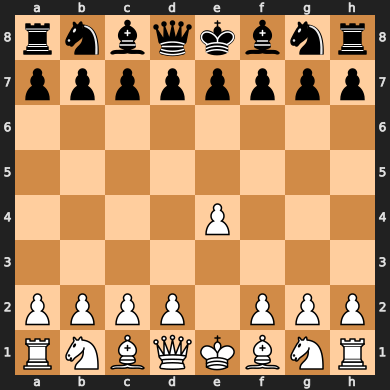

Position after move 2: e5


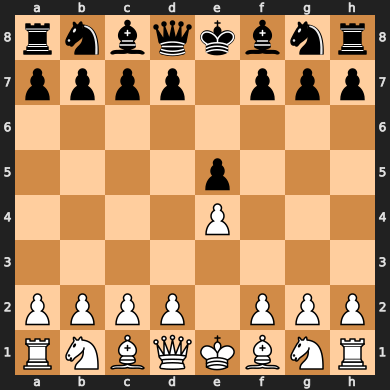

Position after move 3: Nf3


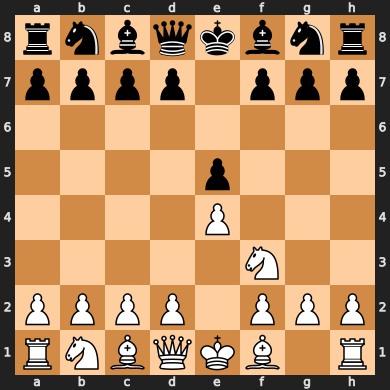

Position after move 4: Nc6


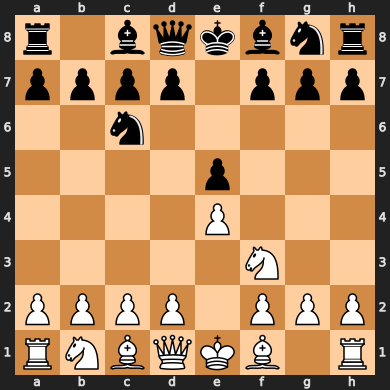

Position after move 5: Bb5


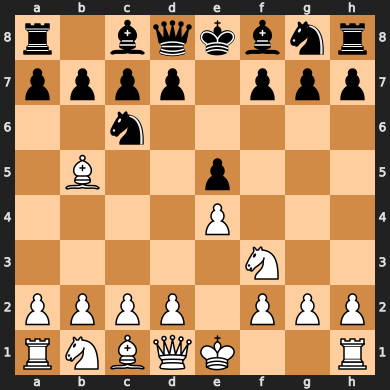

Position after move 6: d6


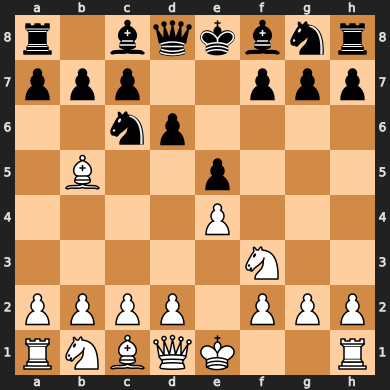

Position after move 7: d4


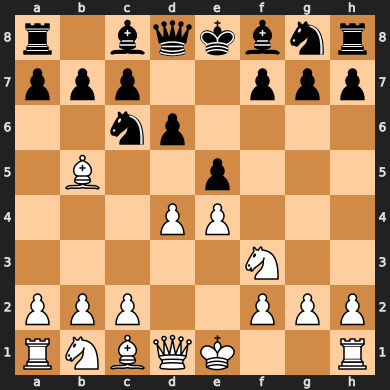

In [1]:
import chess
import chess.svg
from IPython.display import display, SVG
import re

# The move sequence generated by your model
moves = "e4 e5 Nf3 Nc6 Bb5 d6 d4".split()

# Initialize the chess board
board = chess.Board()

# Function to display the current board position
def display_board_svg(board, move_num):
    svg_data = chess.svg.board(board)
    display(SVG(svg_data))

# Loop through the moves and update the board
for move_num, move in enumerate(moves, start=1):
    # Parse the move and push it onto the board
    try:
        board.push_san(move)
    except ValueError:
        print(f"Invalid move: {move}")
        break
    
    # Display the board after each move
    print(f"Position after move {move_num}: {move}")
    display_board_svg(board, move_num)


/Users/robertbecker/miniconda3/envs/env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Position after move 1: e4


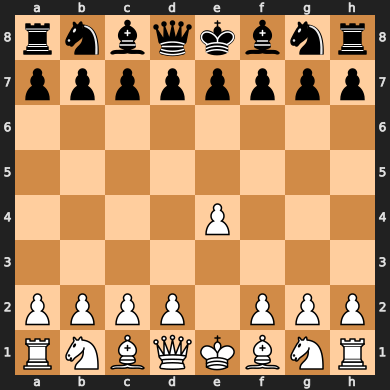

Position after move 2: e5


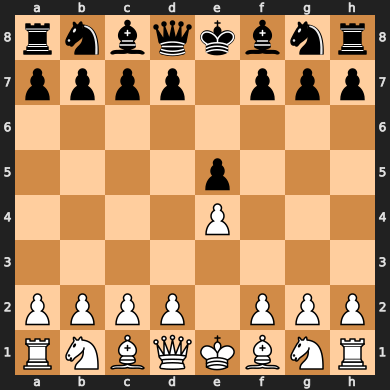

Position after move 3: Nf3


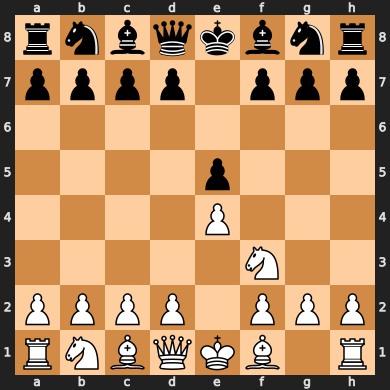

Position after move 4: Nc6


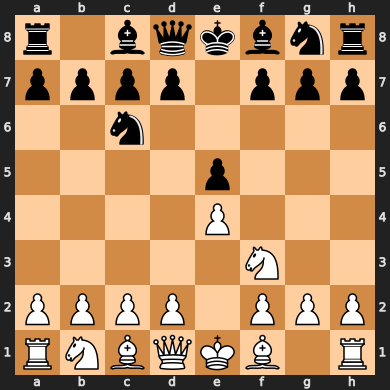

Position after move 5: Bb5


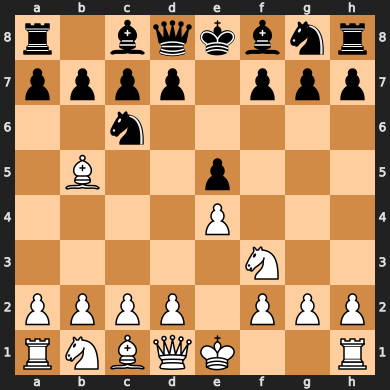

Position after move 6: d6


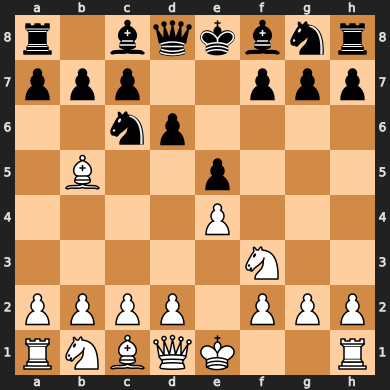

Position after move 7: Bxc6


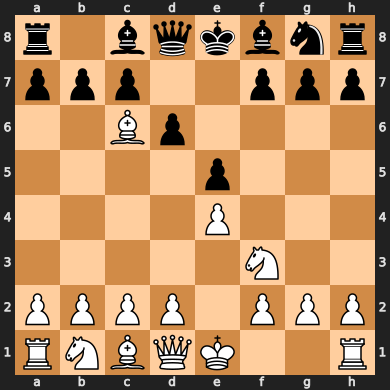

Position after move 8: bxc6


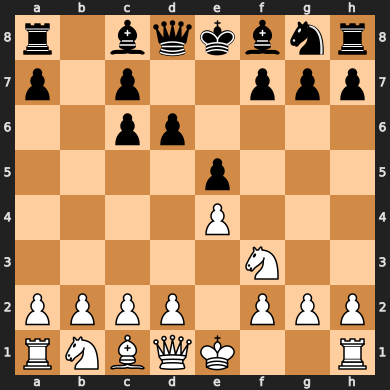

Invalid move: [UNK]


In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import chess
import chess.svg
from IPython.display import display, SVG

# Load the fine-tuned model and tokenizer
model_path = "chess_gpt_from_scratch"  # Replace with your saved model path
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

# Define an initial prompt (you can start from scratch or give an opening move)
prompt = "e4 e5"  # Initial moves; replace with any starting sequence or leave empty for no initial moves

# Tokenize the prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Generate 10 moves
output = model.generate(input_ids, max_length=input_ids.shape[1] + 10, do_sample=True)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Parse the moves and initialize the chess board
moves = generated_text.split()
board = chess.Board()

# Function to display the current board position
def display_board_svg(board, move_num):
    svg_data = chess.svg.board(board)
    display(SVG(svg_data))

# Loop through the moves and update the board
for move_num, move in enumerate(moves, start=1):
    try:
        board.push_san(move)
    except ValueError:
        print(f"Invalid move: {move}")
        break
    
    # Display the board after each move
    print(f"Position after move {move_num}: {move}")
    display_board_svg(board, move_num)


In [ ]:
# Install the Stockfish Python library if you haven’t already:
# !pip install stockfish

from stockfish import Stockfish

# Initialize Stockfish with the path to the binary
stockfish = Stockfish(path="/opt/homebrew/bin/stockfish", depth=18, parameters={"Threads": 2, "Minimum Thinking Time": 30})

# Set the starting position
stockfish.set_position([])

# Display the best moves for the first 10 turns
for turn in range(10):
    best_move = stockfish.get_best_move()
    if best_move is None:
        print("Game over or no legal moves left.")
        break

    # Display the best move
    print(f"Turn {turn + 1}: {best_move}")

    # Update the position with the chosen move
    stockfish.make_moves_from_current_position([best_move])

    # Optional: Display board visual for reference (if you're running in a terminal)
    print(stockfish.get_board_visual())


Turn 1: e2e4
+---+---+---+---+---+---+---+---+
| r | n | b | q | k | b | n | r | 8
+---+---+---+---+---+---+---+---+
| p | p | p | p | p | p | p | p | 7
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 6
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 5
+---+---+---+---+---+---+---+---+
|   |   |   |   | P |   |   |   | 4
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 3
+---+---+---+---+---+---+---+---+
| P | P | P | P |   | P | P | P | 2
+---+---+---+---+---+---+---+---+
| R | N | B | Q | K | B | N | R | 1
+---+---+---+---+---+---+---+---+
  a   b   c   d   e   f   g   h

Turn 2: c7c5
+---+---+---+---+---+---+---+---+
| r | n | b | q | k | b | n | r | 8
+---+---+---+---+---+---+---+---+
| p | p |   | p | p | p | p | p | 7
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 6
+---+---+---+---+---+---+---+---+
|   |   | p |   |   |   |   |   | 5
+---+---+---+---+---+---+---+---+
|   |   |   |   | P |   |   |   |

Turn 1: e4


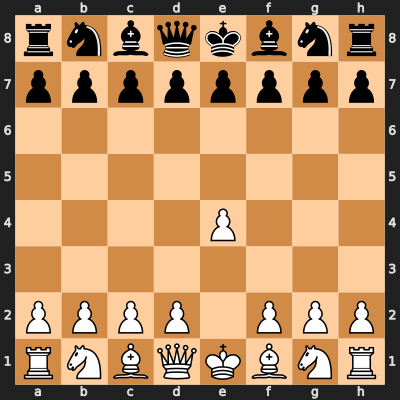

Turn 2: c5


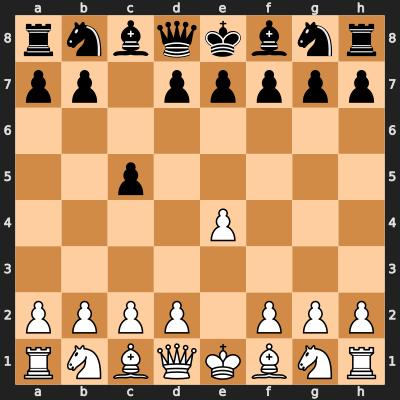

Turn 3: Nf3


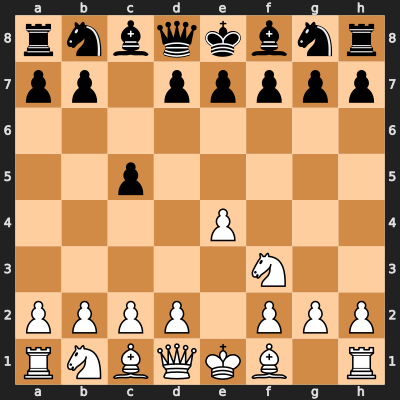

Turn 4: Nc6


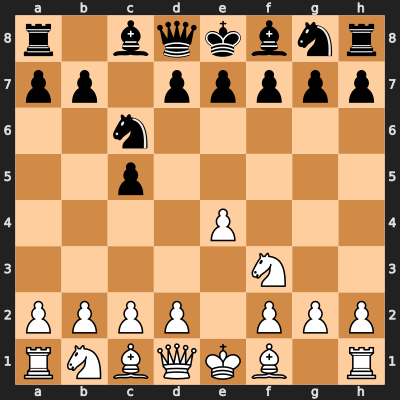

Turn 5: d4


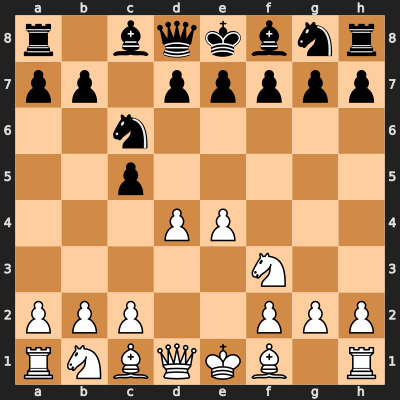

Turn 6: cxd4


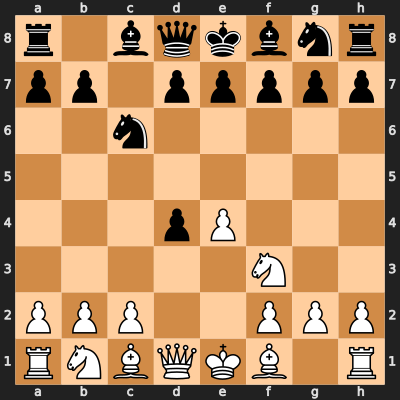

Turn 7: Nxd4


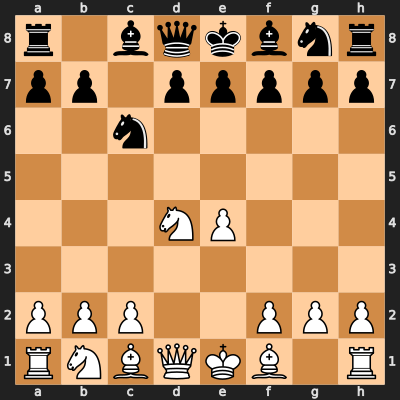

Turn 8: e5


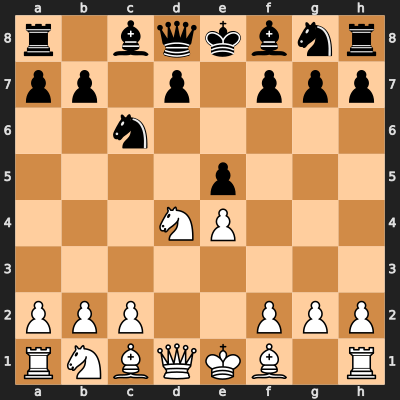

Turn 9: Nb5


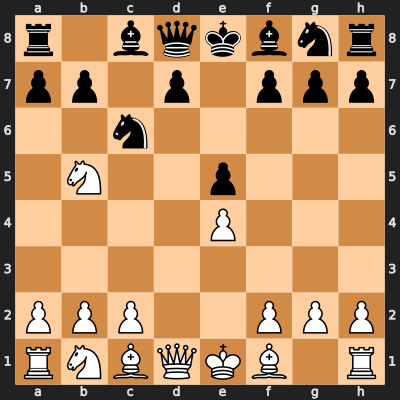

Turn 10: a6


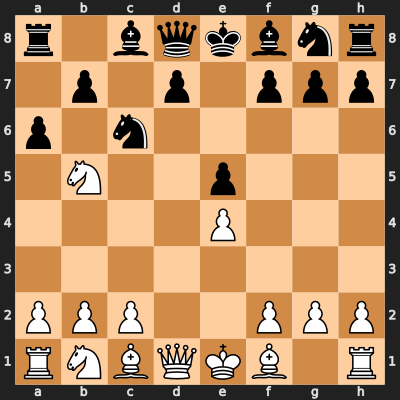

In [5]:
import chess
import chess.svg
from stockfish import Stockfish
from IPython.display import SVG, display

# Initialize Stockfish with the path to the binary
stockfish = Stockfish(path="/opt/homebrew/bin/stockfish", depth=18, parameters={"Threads": 2, "Minimum Thinking Time": 30})

# Set up the board in python-chess
board = chess.Board()

# Make sure Stockfish's initial position matches python-chess board
stockfish.set_position([])

# Display the first 10 moves made by Stockfish
for turn in range(10):
    # Get the best move from Stockfish in UCI format
    best_move_uci = stockfish.get_best_move()
    if best_move_uci is None:
        print("Game over or no legal moves left.")
        break
    
    # Convert UCI move to python-chess Move object
    move = chess.Move.from_uci(best_move_uci)
    
    # Verify the move is legal
    if move not in board.legal_moves:
        print(f"Illegal move: {best_move_uci}")
        break
    
    # Get SAN notation before pushing the move
    san_move = board.san(move)
    
    # Make the move on both the python-chess board and Stockfish
    board.push(move)
    stockfish.set_position([m.uci() for m in board.move_stack])
    
    # Display the move
    print(f"Turn {turn + 1}: {san_move}")
    display(SVG(chess.svg.board(board=board, size=400)))


=== Turn 1 ===

Position evaluation: +0.21 pawns

Top 3 moves being considered:
1. e2e4 (eval: +0.26)
2. d2d4 (eval: +0.22)
3. g1f3 (eval: +0.19)

Chose move: e4


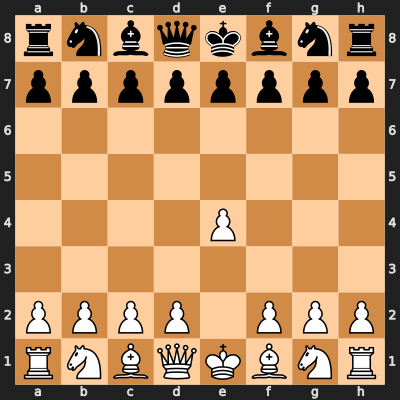


=== Turn 2 ===

Position evaluation: +0.36 pawns

Top 3 moves being considered:
1. e7e5 (eval: +0.28)
2. c7c5 (eval: +0.35)
3. e7e6 (eval: +0.44)

Chose move: e5


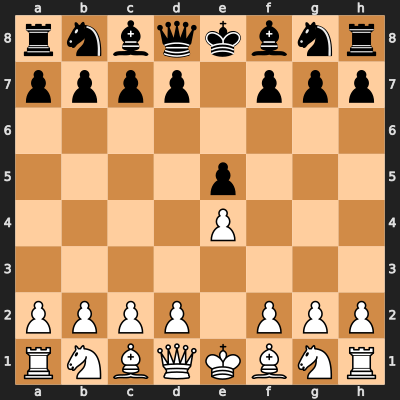


=== Turn 3 ===

Position evaluation: +0.05 pawns

Top 3 moves being considered:
1. g1f3 (eval: +0.28)
2. b1c3 (eval: +0.18)
3. f1c4 (eval: +0.09)

Chose move: Nf3


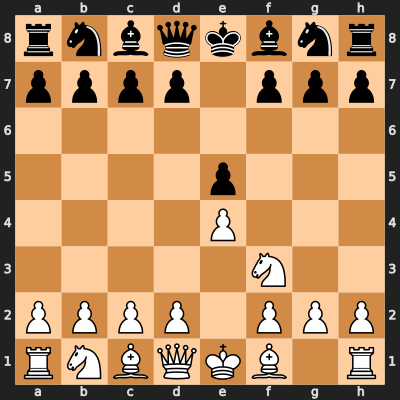


=== Turn 4 ===

Position evaluation: +0.45 pawns

Top 3 moves being considered:
1. b8c6 (eval: +0.27)
2. d7d6 (eval: +0.43)
3. g8f6 (eval: +0.45)

Chose move: Nc6


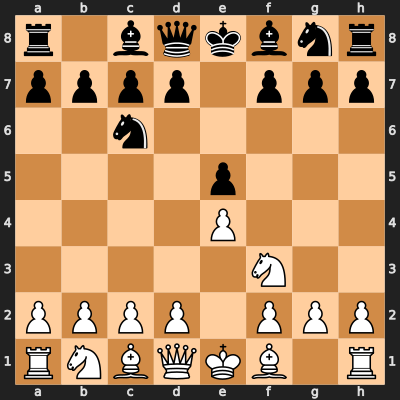


=== Turn 5 ===

Position evaluation: +0.16 pawns

Top 3 moves being considered:
1. f1b5 (eval: +0.30)
2. f1c4 (eval: +0.17)
3. b1c3 (eval: +0.11)

Chose move: Bb5


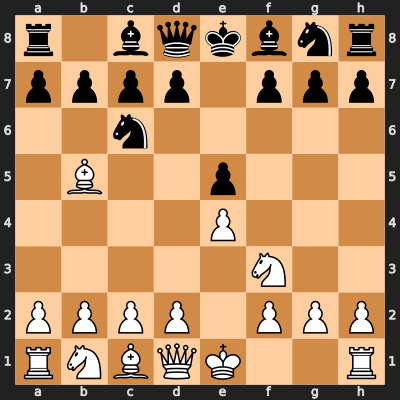


=== Turn 6 ===

Position evaluation: +0.46 pawns

Top 3 moves being considered:
1. g8f6 (eval: +0.30)
2. a7a6 (eval: +0.32)
3. f8e7 (eval: +0.36)

Chose move: Nf6


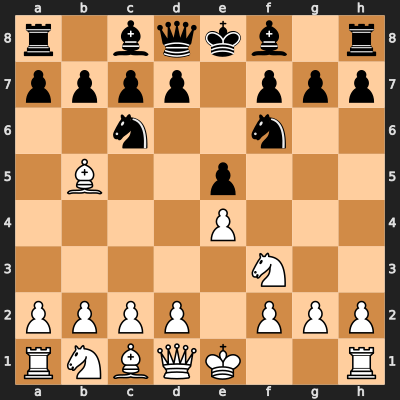


=== Turn 7 ===

Position evaluation: +0.19 pawns

Top 3 moves being considered:
1. e1g1 (eval: +0.25)
2. d2d3 (eval: +0.21)
3. b1c3 (eval: +0.10)

Chose move: O-O


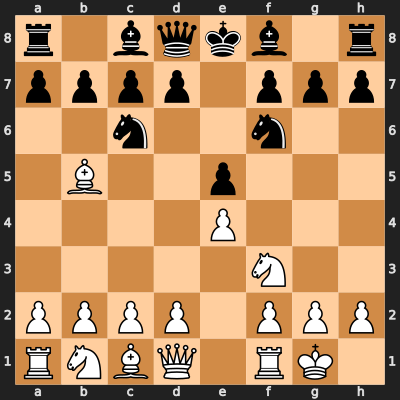


=== Turn 8 ===

Position evaluation: +0.50 pawns

Top 3 moves being considered:
1. f6e4 (eval: +0.20)
2. f8e7 (eval: +0.47)
3. d7d6 (eval: +0.48)

Chose move: Nxe4


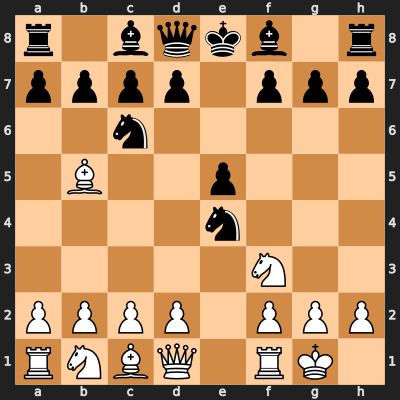


=== Turn 9 ===

Position evaluation: -0.05 pawns

Top 3 moves being considered:
1. f1e1 (eval: +0.21)
2. d2d4 (eval: +0.09)
3. d1e1 (eval: +0.00)

Chose move: Re1


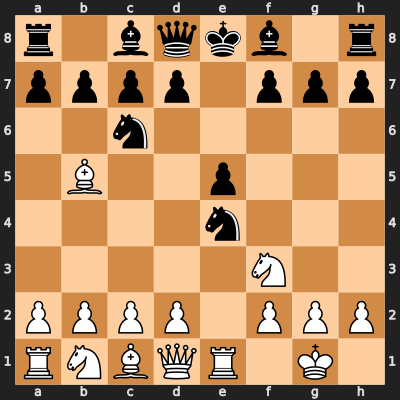


=== Turn 10 ===

Position evaluation: +1.51 pawns

Top 3 moves being considered:
1. e4d6 (eval: +0.26)
2. e4f6 (eval: +0.47)
3. f7f5 (eval: +1.73)

Chose move: Nd6


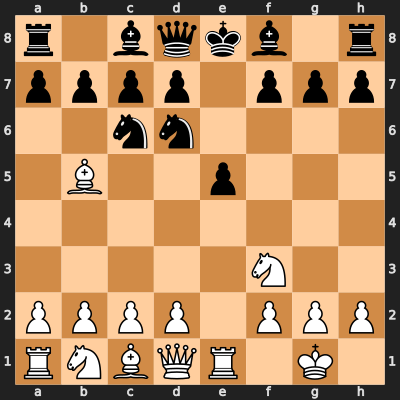

In [6]:
import chess
import chess.svg
from stockfish import Stockfish
from IPython.display import SVG, display

# Initialize Stockfish with longer thinking time to get better analysis
stockfish = Stockfish(
    path="/opt/homebrew/bin/stockfish",
    depth=18,
    parameters={
        "Threads": 2,
        "Minimum Thinking Time": 1000,  # Increased thinking time for better analysis
        "MultiPV": 3  # Show top 3 moves being considered
    }
)

# Set up the board in python-chess
board = chess.Board()

# Make sure Stockfish's initial position matches python-chess board
stockfish.set_position([])

def print_evaluation(stockfish):
    """Print detailed evaluation of the position"""
    # Get centipawn score
    eval_score = stockfish.get_evaluation()
    if eval_score['type'] == 'cp':
        score = eval_score['value'] / 100  # Convert centipawns to pawns
        print(f"\nPosition evaluation: {score:+.2f} pawns")
    else:
        # If it's a forced mate
        print(f"\nMate in {eval_score['value']} moves")
    
    # Get top moves being considered
    top_moves = stockfish.get_top_moves(3)
    print("\nTop 3 moves being considered:")
    for i, move_info in enumerate(top_moves, 1):
        move = move_info['Move']
        score = move_info['Centipawn']/100 if 'Centipawn' in move_info else 'M' + str(move_info['Mate'])
        print(f"{i}. {move} (eval: {score:+.2f})")

# Display the first 10 moves made by Stockfish
for turn in range(10):
    print(f"\n=== Turn {turn + 1} ===")
    
    # Show analysis before making the move
    print_evaluation(stockfish)
    
    # Get the best move from Stockfish in UCI format
    best_move_uci = stockfish.get_best_move()
    if best_move_uci is None:
        print("Game over or no legal moves left.")
        break
    
    # Convert UCI move to python-chess Move object
    move = chess.Move.from_uci(best_move_uci)
    
    # Verify the move is legal
    if move not in board.legal_moves:
        print(f"Illegal move: {best_move_uci}")
        break
    
    # Get SAN notation before pushing the move
    san_move = board.san(move)
    
    # Make the move on both the python-chess board and Stockfish
    board.push(move)
    stockfish.set_position([m.uci() for m in board.move_stack])
    
    # Display the move
    print(f"\nChose move: {san_move}")
    display(SVG(chess.svg.board(board=board, size=400)))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



=== Move 1 ===

Stockfish to move (White):
Position evaluation: +0.21 pawns
Top 3 moves considered:
1. e2e4 (eval: +0.35)
2. d2d4 (eval: +0.20)
3. g1f3 (eval: +0.19)
Stockfish plays: e4


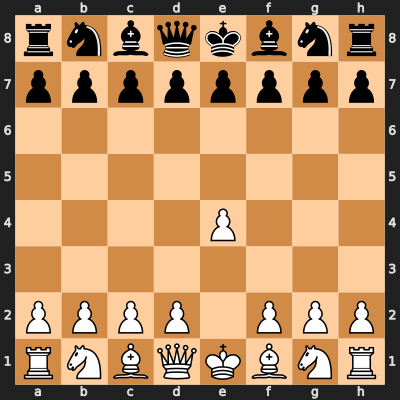

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Move 2 ===

GPT to move (Black):
Prompt sent to GPT: '1. e4'
Full GPT response: '1. e4 d6'
GPT plays: d6
Position evaluation: +0.38 pawns
Top 3 moves considered:
1. d2d4 (eval: +0.51)
2. g1f3 (eval: +0.32)
3. b1c3 (eval: +0.31)


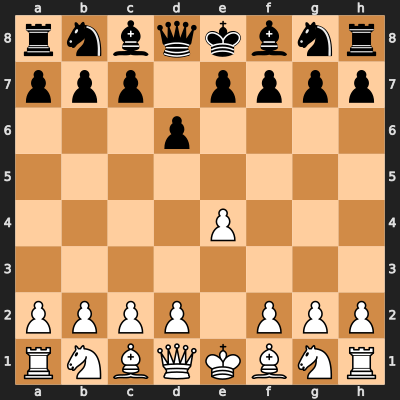


=== Move 3 ===

Stockfish to move (White):
Position evaluation: +0.32 pawns
Top 3 moves considered:
1. d2d4 (eval: +0.49)
2. g1f3 (eval: +0.31)
3. b1c3 (eval: +0.28)
Stockfish plays: d4


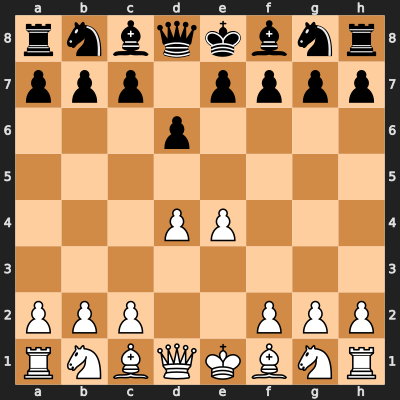

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Move 4 ===

GPT to move (Black):
Prompt sent to GPT: '1. e4 d6 2. d4'
Full GPT response: '1. e4 d6 2. d4 f5'
GPT plays: f5
Position evaluation: +0.98 pawns
Top 3 moves considered:
1. e4f5 (eval: +1.13)
2. b1c3 (eval: +1.12)
3. b1d2 (eval: +0.84)


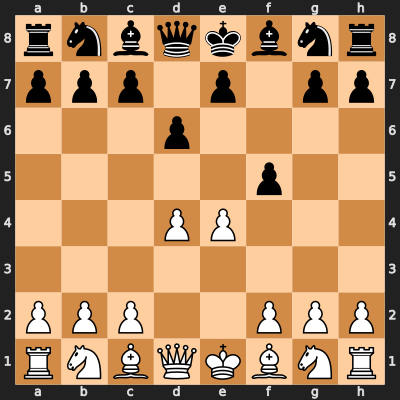


=== Move 5 ===

Stockfish to move (White):
Position evaluation: +0.80 pawns
Top 3 moves considered:
1. e4f5 (eval: +1.12)
2. b1c3 (eval: +1.11)
3. b1d2 (eval: +0.86)
Stockfish plays: Nc3


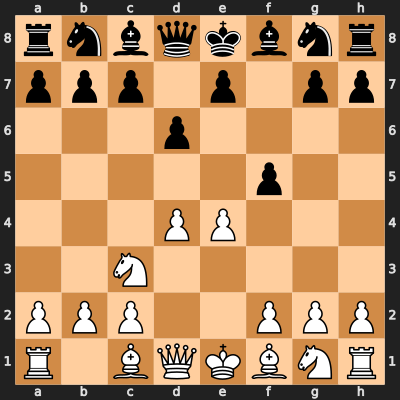

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Move 6 ===

GPT to move (Black):
Prompt sent to GPT: '1. e4 d6 2. d4 f5 3. Nc3'
Full GPT response: '1. e4 d6 2. d4 f5 3. Nc3 Bg'
GPT made an illegal move: Bg
Game Over - Stockfish wins by illegal move!

Final position reached:


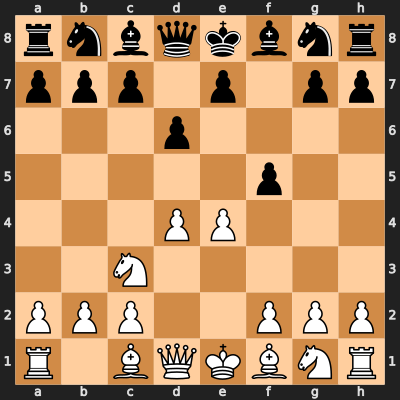


Move history:
e4 d6 d4 f5 Nc3


In [14]:
import chess
import chess.svg
from stockfish import Stockfish
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from IPython.display import display, SVG

# Initialize Stockfish
stockfish = Stockfish(
    path="/opt/homebrew/bin/stockfish",
    depth=18,
    parameters={
        "Threads": 2,
        "Minimum Thinking Time": 1000,
        "MultiPV": 3
    }
)

# Load GPT model
model_path = "fine_tuned_gpt2_chess"
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
model.eval()

# Initialize the game
board = chess.Board()
move_history = []

def get_gpt_move(current_position):
    """Get GPT's next move based on the current game history"""
    # Format moves with turn numbers
    formatted_moves = []
    for i, move in enumerate(move_history):
        if i % 2 == 0:
            formatted_moves.append(f"{(i//2)+1}. {move}")
        else:
            formatted_moves.append(move)
    
    # Join moves with proper spacing
    prompt = " ".join(formatted_moves)
    
    print(f"Prompt sent to GPT: '{prompt}'")  # Debug print
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    
    # Generate next move
    output = model.generate(
        input_ids, 
        max_length=input_ids.shape[1] + 2,
        do_sample=True,
        num_return_sequences=1
    )
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    print(f"Full GPT response: '{generated_text}'")  # Debug print
    
    # Extract the last move from the generated sequence
    moves = generated_text.split()
    return moves[-1] if moves else None

def print_position_eval():
    """Print Stockfish's evaluation of the current position"""
    eval_score = stockfish.get_evaluation()
    if eval_score['type'] == 'cp':
        score = eval_score['value'] / 100
        print(f"Position evaluation: {score:+.2f} pawns")
    else:
        print(f"Mate in {eval_score['value']} moves")
    
    # Show top moves being considered
    top_moves = stockfish.get_top_moves(3)
    print("Top 3 moves considered:")
    for i, move_info in enumerate(top_moves, 1):
        move = move_info['Move']
        score = move_info['Centipawn']/100 if 'Centipawn' in move_info else 'M' + str(move_info['Mate'])
        print(f"{i}. {move} (eval: {score:+.2f})")

def update_stockfish_position():
    """Update Stockfish's internal position to match the current board"""
    moves_uci = [move.uci() for move in board.move_stack]
    stockfish.set_position(moves_uci)

# Play the game
for move_num in range(20):  # Let's play 20 moves or until game ends
    print(f"\n=== Move {move_num + 1} ===")
    
    # Stockfish's turn (White)
    if move_num % 2 == 0:
        print("\nStockfish to move (White):")
        update_stockfish_position()  # Make sure Stockfish knows the current position
        print_position_eval()
        
        best_move_uci = stockfish.get_best_move()
        if best_move_uci is None:
            print("Game over - no legal moves!")
            break
            
        # Convert UCI move to SAN for display and history
        move = chess.Move.from_uci(best_move_uci)
        san_move = board.san(move)
        
        # Make the move
        board.push(move)
        move_history.append(san_move)
        
        print(f"Stockfish plays: {san_move}")
        display(SVG(chess.svg.board(board=board, size=400)))
    
    # GPT's turn (Black)
    else:
        print("\nGPT to move (Black):")
        gpt_move = get_gpt_move(" ".join(move_history))
        
        try:
            # Verify and make the move
            chess_move = board.push_san(gpt_move)
            move_history.append(gpt_move)
            update_stockfish_position()  # Update Stockfish after GPT's move
            
            print(f"GPT plays: {gpt_move}")
            print_position_eval()
            display(SVG(chess.svg.board(board=board, size=400)))
            
        except ValueError as e:
            print(f"GPT made an illegal move: {gpt_move}")
            print("Game Over - Stockfish wins by illegal move!")
            break
    
    # Check if game is over
    if board.is_game_over():
        result = board.outcome()
        print("\nGame Over!")
        print(f"Result: {result.result()}")
        print(f"Termination: {result.termination}")
        break

# Print final position
print("\nFinal position reached:")
display(SVG(chess.svg.board(board=board, size=400)))
print("\nMove history:")
print(" ".join(move_history))